- 참조 

  - 텐서플로우 공식 홈페이지

# 뉴럴 스타일 트랜스퍼(Neural Style Transfer)

- 원하는 이미지를 다른 스타일의 이미지로 구성하는 기법

- 이 기법은 Neural Style Transfer로 알려져있으며, Leon A. Gatys의 논문 A Neural Algorithm of Artistic Style에 잘 기술되어 있음

- Neural style transfer은 콘텐츠 (content) 이미지와 (유명한 작가의 삽화와 같은) 스타일 참조 (style reference) 이미지를 이용하여, 콘텐츠 이미지의 콘텐츠는 유지하되 스타일 참조 이미지의 화풍으로 채색한 것 같은 새로운 이미지를 생성하는 최적화 기술

- 이 과정은 출력 이미지를 콘텐츠 이미지의 콘텐츠 통계랑(statistic)과 스타일 참조 이미지의 스타일 통계량에 맞춰 최적화시킴으로써 구현되며 통계량은 합성곱 신경망을 이용해 각각의 이미지에서 추출

- 코드 참조 : https://www.tensorflow.org/tutorials/generative/style_transfer


In [1]:
import tensorflow as tf
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [2]:
def tensor_to_image(tensor):
  tensor = tensor * 255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor) > 3:
    assert tensor.shape[0] ==1
    tensor = tensor[0]

  return PIL.Image.fromarray(tensor)

* Image: https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg
* Style: https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg

In [3]:
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')

style_path = tf.keras.utils.get_file('Kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

196608/195196 [==============================] - 0s 0us/step


### 입력 시각화

- 이미지를 불러오는 함수를 정의하고, 최대 이미지 크기를 512개의 픽셀로 제한

In [4]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale , tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

- 이미지를 출력하기 위한 간단한 함수를 정의

In [5]:
def imshow(image , title =None):
  if len(image.shape) >  3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

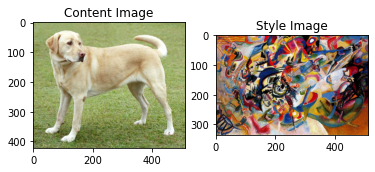

In [6]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1,2,1)
imshow(content_image, 'Content Image')
plt.subplot(1,2,2)
imshow(style_image, 'Style Image')

## TF-Hub를 통한 빠른 스타일 전이

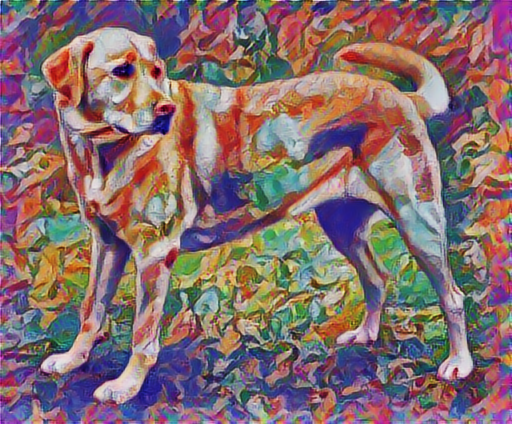

In [7]:
import tensorflow_hub as  hub
hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/1')
stylized_image = hub_module(tf.constant(content_image),tf.constant(style_image))[0]
tensor_to_image(stylized_image)

## 콘텐츠와 스타일 표현 정의하기

- 모델의 입력층부터 시작해서, 처음 몇 개의 층은 선분이나 질감과 같은 이미지 내의 저차원적 특성에 반응

  - 반면, 네트워크가 깊어지면 최종 몇 개의 층은 바퀴나 눈과 같은 고차원적 특성들을 나타냄
  
- 이번 경우, 우리는 사전학습된 이미지 분류 네트워크인 VGG19 네트워크의 구조를 사용할 것이고,  
  이 중간층들은 이미지에서 콘텐츠와 스타일 표현을 정의하는 데 필요
  
  - 입력 이미지가 주어졌을때, 스타일 전이 알고리즘은 이 중간층들에서 콘텐츠와 스타일에 해당하는 타깃 표현들을 일치시키려고 시도할 것

In [8]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224,224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

574717952/574710816 [==============================] - 12s 0us/step


TensorShape([1, 1000])

In [9]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

40960/35363 [==================================] - 0s 0us/step


[('Labrador_retriever', 0.49317113),
 ('golden_retriever', 0.23665294),
 ('kuvasz', 0.03635755),
 ('Chesapeake_Bay_retriever', 0.024182769),
 ('Greater_Swiss_Mountain_dog', 0.018646104)]

- 분류층을 제외한 VGG19 모델을 불러오고, 각 층의 이름을 출력

In [10]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

for layer in vgg.layers:
  print(layer.name)

80142336/80134624 [==============================] - 3s 0us/step
input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


- 이미지의 스타일과 콘텐츠를 나타내기 위한 모델의 중간층들을 선택

In [11]:
content_layers = ['block5_conv2']
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

### 스타일과 콘텐츠를 위한 중간층

- 사전훈련된 이미지 분류 네트워크 속에 있는 중간 출력으로 어떻게 스타일과 콘텐츠 표현을 정의할 수 있을까?

  - 고수준에서 보면 (네트워크의 훈련 목적인) 이미지 분류를 수행하기 위해서는 네트워크가 반드시 이미지를 이해해야한다.
  
  - 이는 미가공 이미지를 입력으로 받아 픽셀값들을 이미지 내에 존재하는 특성(feature)들에 대한 복합적인 이해로 변환할 수 있는 내부 표현(internal representation)을 만드는 작업이 포함

  - 또한 부분적으로 왜 합성곱(convolutional) 신경망의 일반화(generalize)가 쉽게 가능한지를 나타냄  
    즉, 합성곱 신경망은 배경잡음(background noise)과 기타잡음(nuisances)에 상관없이 (고양이와 강아지와 같이)클래스 안에 있는 불변성(invariance)과 특징을 포착할 수 있음
    
  - 따라서 미가공 이미지의 입력과 분류 레이블(label)의 출력 중간 어딘가에서 모델은 복합 특성(complex feature) 추출기의 역할을 수행
  
  - 그러므로, 모델의 중간층에 접근함으로써 입력 이미지의 콘텐츠와 스타일을 추출할 수 있음

### 모델 생성

- 함수형 API를 이용해 모델을 정의하기 위해서는 모델의 입력과 출력을 지정

- `model = Model(inputs, outputs)`


In [12]:
def vgg_layers(layer_names):
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [13]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

for name, output in zip(style_layers, style_outputs):
  print(name)
  print(' - 크기: ',output.numpy().shape)
  print(' - 최소값: ',output.numpy().min())
  print(' - 최대값: ',output.numpy().max())
  print(' - 평균: ',output.numpy().mean())
  print()

block1_conv1
 - 크기:  (1, 336, 512, 64)
 - 최소값:  0.0
 - 최대값:  835.5256
 - 평균:  33.97525

block2_conv1
 - 크기:  (1, 168, 256, 128)
 - 최소값:  0.0
 - 최대값:  4625.8857
 - 평균:  199.82687

block3_conv1
 - 크기:  (1, 84, 128, 256)
 - 최소값:  0.0
 - 최대값:  8789.239
 - 평균:  230.78099

block4_conv1
 - 크기:  (1, 42, 64, 512)
 - 최소값:  0.0
 - 최대값:  21566.135
 - 평균:  791.24005

block5_conv1
 - 크기:  (1, 21, 32, 512)
 - 최소값:  0.0
 - 최대값:  3189.2542
 - 평균:  59.179478



### 스타일 계산

- 이미지의 콘텐츠는 중간층들의 특성 맵(feature map)의 값들로 표현

- 이미지의 스타일은 각 특성 맵의 평균과 피쳐맵들 사이의 상관관계로 설명할 수 있음

  - 이런 정보를 담고 있는 그람 행렬(Gram matrix)은 각 위치에서 특성 벡터(feature vector)끼리의 외적을 구한 후,평균값을 냄으로써 구할 수 있음 
  
  - 주어진 층에 대한 그람 행렬은 다음과 같이 계산

  ## $$ G^l_{cd} = \frac{\sum_{ij}F^l_{ijc}(x)F^l_{ijd}(x)}{IJ}$$

이 식은 `tf.linalg.einsum` 함수를 통해 쉽게 계산할 수 있습니다:

In [14]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc, bijd -> bcd',input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2],tf.float32)
  return result / (num_locations)

### 스타일과 컨텐츠 추출

- 스타일과 컨텐츠 텐서를 반환하는 모델

In [15]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers )
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    inputs = inputs * 255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[:self.num_style_layers])
    style_outputs = [gram_matrix(style_output) for style_output in style_outputs]

    content_dict = {content_name:value for content_name, value in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value for style_name, value in zip(self.style_layers, style_outputs)}

    return {'content':content_dict, 'style':style_dict}

- 이미지가 입력으로 주어졌을때, 이 모델은 `style_layers`의 스타일과 `content_layers`의 콘텐츠에 대한 그람 행렬을 출력

In [16]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Style: ')
for name, output in sorted(results['style'].items()):
  print(name)
  print(' - 크기: ',output.numpy().shape)
  print(' - 최소값: ',output.numpy().min())
  print(' - 최대값: ',output.numpy().max())
  print(' - 평균: ',output.numpy().mean())
  print()


print('Content: ')
for name, output in sorted(results['content'].items()):
  print(name)
  print(' - 크기: ',output.numpy().shape)
  print(' - 최소값: ',output.numpy().min())
  print(' - 최대값: ',output.numpy().max())
  print(' - 평균: ',output.numpy().mean())
  print()

Style: 
block1_conv1
 - 크기:  (1, 64, 64)
 - 최소값:  0.0055228444
 - 최대값:  28014.557
 - 평균:  263.79025

block2_conv1
 - 크기:  (1, 128, 128)
 - 최소값:  0.0
 - 최대값:  61479.473
 - 평균:  9100.949

block3_conv1
 - 크기:  (1, 256, 256)
 - 최소값:  0.0
 - 최대값:  545623.44
 - 평균:  7660.976

block4_conv1
 - 크기:  (1, 512, 512)
 - 최소값:  0.0
 - 최대값:  4320501.5
 - 평균:  134288.84

block5_conv1
 - 크기:  (1, 512, 512)
 - 최소값:  0.0
 - 최대값:  110005.37
 - 평균:  1487.0378

Content: 
block5_conv2
 - 크기:  (1, 422, 512, 64)
 - 최소값:  0.0
 - 최대값:  550.1154
 - 평균:  15.226082



### 경사하강법 실행

- 타깃에 대한 입력 이미지의 평균 제곱 오차를 계산한 후, 오차값들의 가중합을 구함

- 스타일과 콘텐츠의 타깃값을 지정합니다

In [17]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

- 최적화시킬 이미지를 담을 `tf.Variable`을 정의하고 콘텐츠 이미지로 초기화

- 이때 `tf.Variable`는 콘텐츠 이미지와 크기가 같아야 한다


In [18]:
image = tf.Variable(content_image)

- 픽셀 값이 실수이므로 [0, 1] 사이로 cliping하는 함수 정의

In [19]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min = 0.0, clip_value_max = 1.0)

- 옵티마이저 생성

In [20]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

- 최적화를 진행하기 위해, 전체 오차를 콘텐츠와 스타일 오차의 가중합으로 정의

In [21]:
style_weight = 1e-2
content_weight = 1e-4

In [22]:
def style_content_loss(outputs):
  style_outputs = outputs['style']
  content_outputs = outputs['content']
  style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) for name in style_outputs.keys()])
  style_loss *= style_weight / num_style_layers

  content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) for name in content_outputs.keys()])
  content_loss *= content_weight / num_content_layers

  loss = style_loss + content_loss

  return loss

- `tf.GradientTape`를 사용해 이미지를 업데이트

In [23]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as  tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad,image)])
  image.assign(clip_0_1(image))

- 구현한 알고리즘 테스트

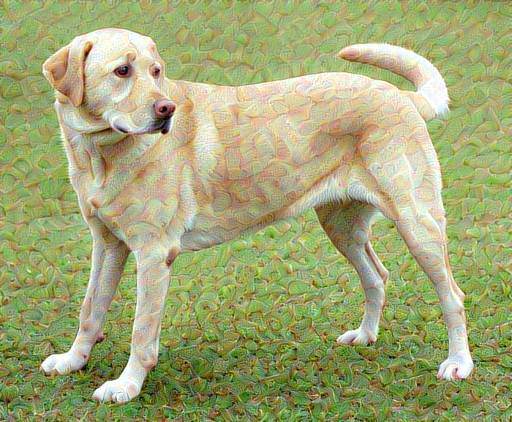

In [24]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

- 더 오랫동안 최적화 진행

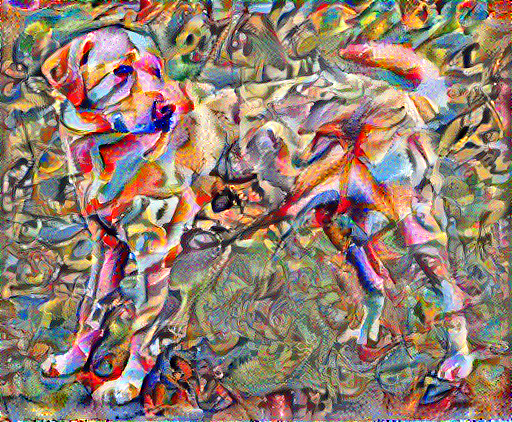

Training step: 1000
Elapsed time: 


In [25]:
import time
start = time.time()
epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print('.',end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print('Training step: {}'.format(step))

end = time.time()
print('Elapsed time: '.format(end-start))

### 총 변위 손실

- 위의 기본 구현 방식의 한 가지 단점은 많은 고주파 아티팩(high frequency artifact)가 생겨난다는 점

- 아티팩 생성을 줄이기 위해서는 이미지의 고주파 구성 요소에 대한 레귤러리제이션(regularization) 항을 추가해야 함

  - 스타일 전이에서는 이 변형된 오차값을 총 변위 손실(total variation loss)라고 함



In [29]:
def high_pass_x_y(image):
  x_var = image[:,:,1:,:] - image[:,:,:-1,:]
  y_var = image[:,1:,:,:] - image[:,:-1,:,:]
  return x_var, y_var

- 아래의 이미지들은 고주파 구성 요소가 늘어났다는 점을 보여줌

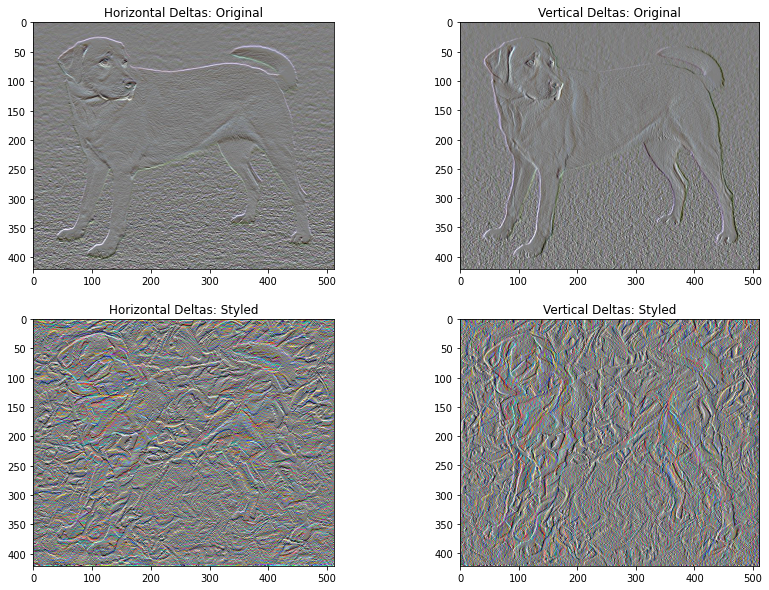

In [30]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
imshow(clip_0_1(2*y_deltas + 0.5), 'Horizontal Deltas: Original')

plt.subplot(2,2,2)
imshow(clip_0_1(2*x_deltas + 0.5), 'Vertical Deltas: Original')

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2,2,3)
imshow(clip_0_1(2*y_deltas + 0.5), 'Horizontal Deltas: Styled')

plt.subplot(2,2,4)
imshow(clip_0_1(2*x_deltas + 0.5), 'Vertical Deltas: Styled')

- (참고)
  - 고주파 구성 요소가 경계선 탐지기의 일종

  - 소벨 경계선 탐지기(Sobel edge detector)를 사용하면 유사한 출력 얻음

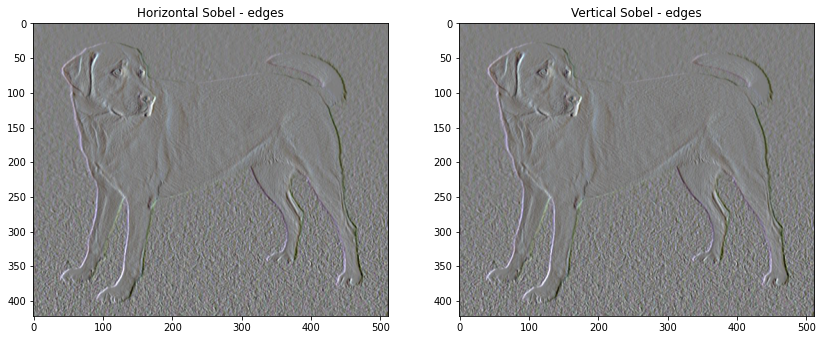

In [32]:
plt.figure(figsize=(14,10))

sobel = tf.image.sobel_edges(content_image)
plt.subplot(1,2,1)
imshow(clip_0_1(sobel[..., 1]/4 + 0.5), 'Horizontal Sobel - edges')
plt.subplot(1,2,2)
imshow(clip_0_1(sobel[..., 1]/4 + 0.5), 'Vertical Sobel - edges')

- 정규화 오차는 각 값의 절대값의 합으로 표현

In [33]:
def total_variation_loss(image):
  x_deltas, y_deltas =high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [34]:
total_variation_loss(image).numpy()

148544.34

- tensorflow에 이미 표준 함수가 내장되어 있음

- 따라서 오차식을 직접 구현할 필요 없음

In [35]:
tf.image.total_variation(image).numpy()

array([148544.34], dtype=float32)

### 다시 최적화 진행하기

In [39]:
total_variations_weight = 30

In [40]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variations_weight * tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad,image)])
  image.assign(clip_0_1(image))

- 최적화할 변수를 다시 초기화

In [41]:
image = tf.Variable(content_image)

- 최적화 수행

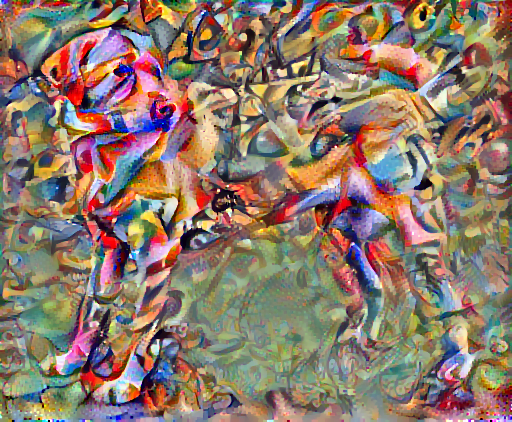

Training step: 1000
Elapsed time: 


In [42]:
import time
start = time.time()
epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print('.',end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print('Training step: {}'.format(step))

end = time.time()
print('Elapsed time: '.format(end-start))

### 결과 저장

In [ ]:
file_name = 'stylized_image.png'
tensor_to_image(image).save(file_name)

for google.colab import files
files.download(file_name)